## Prediction of demand for shared bikes using Linear Regression

<B>BACKGROUND:</B>

Bike share systems allow people to borrow a bike. A US bike-sharing provider BoomBikes has recently suffered 
considerable dips in their revenues and aspires to understand the demand for shared bikes among the people.

The objective is to:
- understand the factors on which demand for shared bikes depend
- which variables are significant in predicting the demand and how well they describe the demand
- perform EDA on the available data and build a optimal model to predict future demand

#### Target Variable
The number of bikes rented on a particular day will be the target variable which we want to predict

#### Import the necessary libraries to perform EDA and Model building

In [135]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for performing regression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import libraries to identify the coefficient of determination
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Import libraries for normalizing data
from sklearn.preprocessing import MinMaxScaler

#### List the software versions used in this implementation

In [136]:
print("Pandas version:\t\t", pd.__version__)
print("statsmodel version: \t", sm.__version__)
print("Seaborn version: \t", sns.__version__)
print("MatplotLib version: \t", matplotlib.__version__)
! python --version

Pandas version:		 1.3.5
statsmodel version: 	 0.10.1
Seaborn version: 	 0.12.2
MatplotLib version: 	 3.3.3
Python 3.7.4


#### Load the data from file into a Dataframe and perform some basic checks on the data

In [3]:
df_bike = pd.read_csv("day.csv")

In [4]:
df_bike.shape

(730, 16)

In [5]:
df_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [125]:
df_bike.describe()

,yr,holiday,workingday,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,23.726384,62.765082,12.763699,4508.006849
std,0.500343,0.167266,0.465405,8.150247,14.237634,5.195640,1936.011647
min,0.000000,0.000000,0.000000,3.950000,0.000000,1.500000,22.000000
25%,0.000000,0.000000,0.000000,16.892500,52.000000,9.040000,3169.750000
50%,0.500000,0.000000,1.000000,24.370000,62.625000,12.130000,4548.500000
75%,1.000000,0.000000,1.000000,30.445000,72.990000,15.627500,5966.000000
max,1.000000,1.000000,1.000000,42.040000,97.250000,34.000000,8714.000000


#### Observations on available raw Data

- Two years data 2018-19 with 730 records one for each day
- 16 columns mostly numerical except the Date field encoded as object
- No NULL values in columns
- NO DUPLICATE rows present
- 'weathersit' and 'season' are ideally categorical variables to be converted to strings
- Some columns can be identified as not useful for analysis
    - instant which is just a sequence of records
    - casual and registered appear to be the breakup of the total cnt of rentals on a day
    - dteday

### Remove columns not useful for Analysis

In [8]:
# Remove columns not useful for analysis

# Drop instant as it is just a sequence number for the records, and dteday as we already have year,month and holiday info
#Anycase day may not be useful and there are different number of days in a month
df_bike.drop(["instant", "dteday"],axis=1,inplace=True)

#Casual and registered together sum up to the target variable cnt. They are not independent and can be dropped.
df_bike.drop(["casual", "registered"],axis=1, inplace=True)

#atemp(feels like temperature) always follows the actual temp. Keep only one if they are highly corelated.
# We could keep temp but it is likely that a person decides to go out based on the felt temperature and not the actual one.
print("Correlation between actual & feels-like temperature:",df_bike["temp"].corr(df_bike['atemp']))
df_bike.drop("temp",axis=1,inplace=True)

Correlation between actual & feels-like temperature: 0.9916961786905648


In [ ]:
# DATA preperation convert weathers it to categorical.

In [12]:
def map_col_values (df,col,dic):
    df.replace({col: dic}, inplace=True)
    
map_col_values(df_bike, "weathersit", {1: 'clear', 2: 'mist', 3: 'snow', 4: 'heavyrain'})
map_col_values (df_bike, "season", {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
map_col_values(df_bike, "mnth", {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'})
map_col_values(df_bike, "weekday", {0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})

In [14]:
# Round some variables for better clarity
df_bike = df_bike.round({"temp": 2, "hum":2, "atemp": 2, "windspeed":2})
df_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,sat,0,mist,18.18,80.58,10.75,985
1,spring,0,Jan,0,sun,0,mist,17.69,69.61,16.65,801
2,spring,0,Jan,0,mon,1,clear,9.47,43.73,16.64,1349
3,spring,0,Jan,0,tue,1,clear,10.61,59.04,10.74,1562
4,spring,0,Jan,0,wed,1,clear,11.46,43.70,12.52,1600


## Section -2 EDA

<AxesSubplot:xlabel='atemp', ylabel='cnt'>

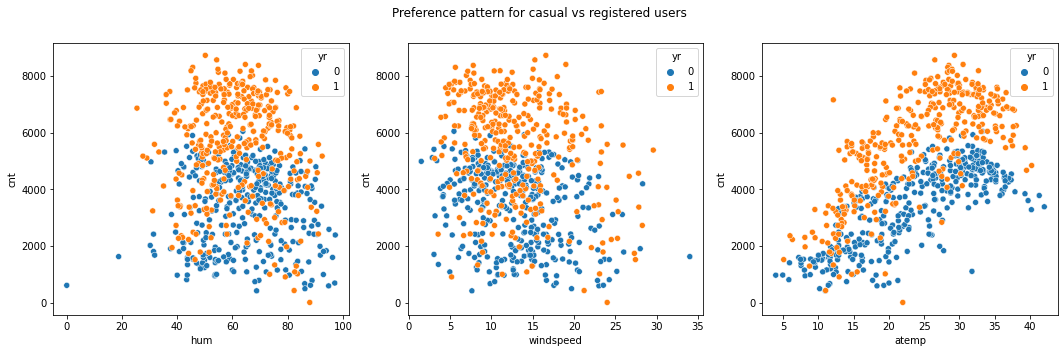

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Preference pattern for casual vs registered users')
sns.scatterplot(ax=axes[0],x="hum",y="cnt", hue='yr',data=df_bike)
sns.scatterplot(ax=axes[1],x="windspeed",y="cnt", hue='yr', data=df_bike)
sns.scatterplot(ax=axes[2],x="atemp",y="cnt", hue='yr', data=df_bike)

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

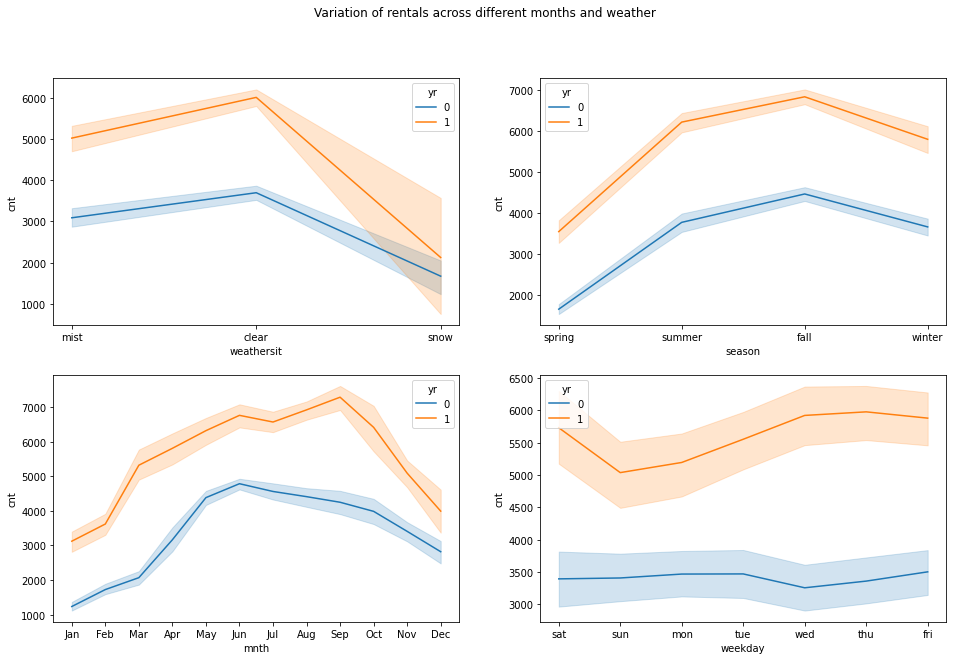

In [19]:
# Findout visually how the rental numbers are with respect to month and weather
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Variation of rentals across different months and weather')

sns.lineplot(ax=axes[0, 0],x = "weathersit", y= "cnt", hue='yr', data = df_bike)
sns.lineplot(ax=axes[0, 1],x = "season", y= "cnt", hue='yr', data=df_bike)
sns.lineplot(ax=axes[1, 0],x = "mnth", y = "cnt", hue='yr', data = df_bike)
sns.lineplot(ax=axes [1, 1],x = "weekday", y = "cnt", hue='yr', data = df_bike)

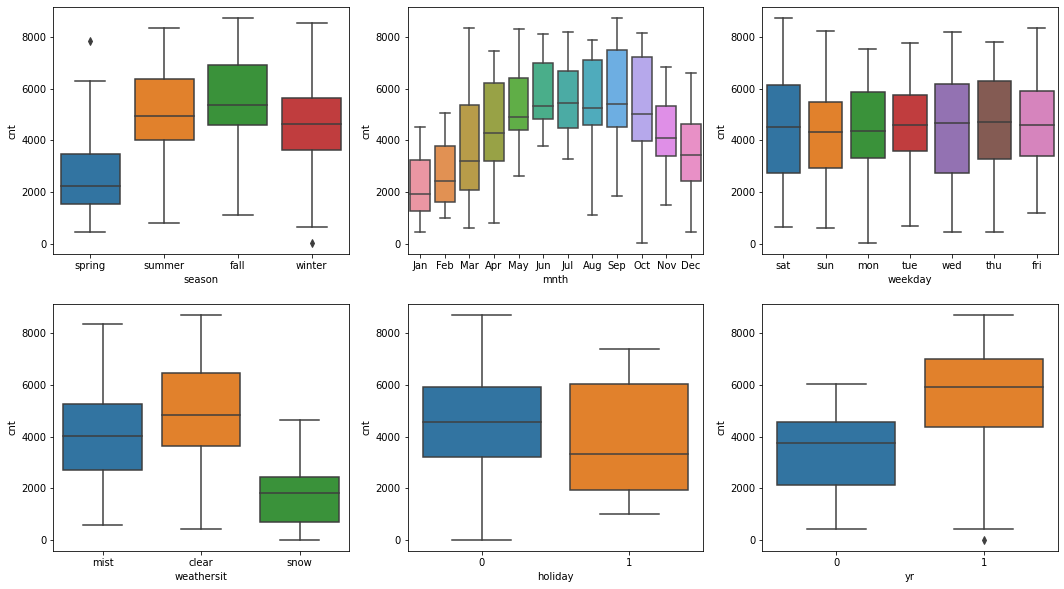

In [20]:
plt.figure(figsize=(18, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_bike)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike)
plt.subplot(2,3,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike)
plt.subplot(2,3,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike)
plt.subplot(2,3,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike)
plt.subplot(2,3,6)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bike)
plt.show()

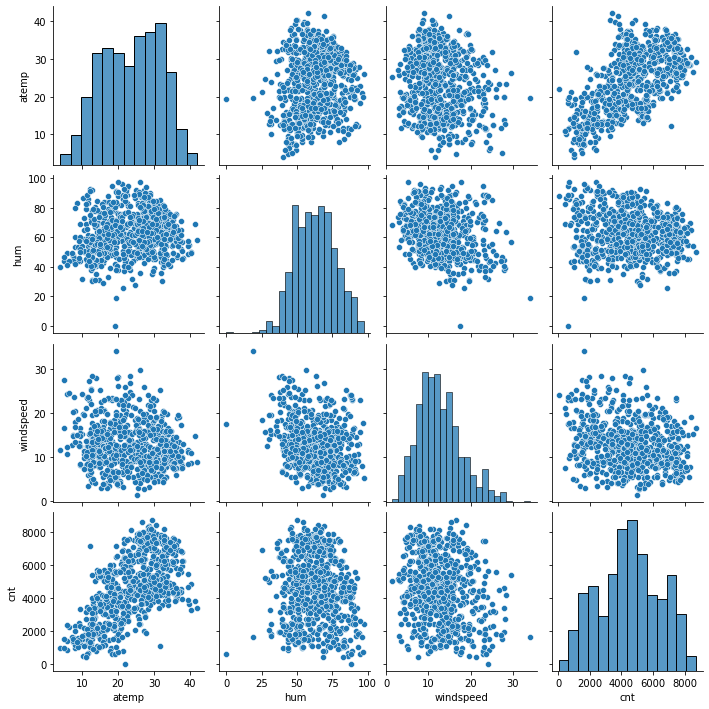

In [23]:
# Plotting the numerical columns

sns.pairplot(data=df_bike, vars=['atemp','hum','windspeed','cnt'])
plt.show()

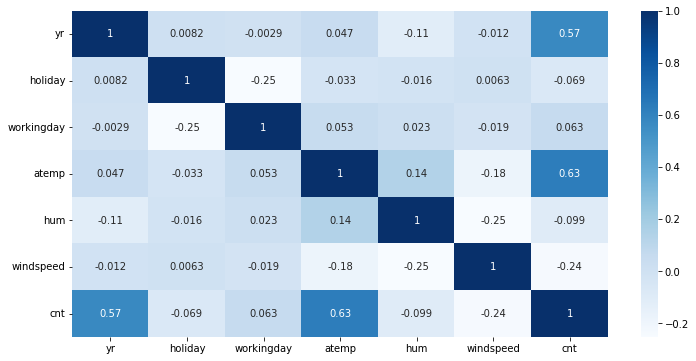

In [25]:
fig,ax = plt.subplots(figsize=(12,6))

sns.heatmap(df_bike.corr(), annot = True, ax=ax, cmap="Blues")
plt.show()

### Conclusions

From the scatter plots for Humidity, Windspeed & Temperature Vs Count
- we see good linear relationship pattern for temperature indicating the warmer the air, people are comfortable to go more outside and the demand for bike increases
- Windspeed & Humidity does not show a clear pattern against the rental count

From the line plot
- The pattern is consistent across the 2 years where Clear weather which happens typically during the summer to fall season which is Apr to Oct attracts more people outside and hence the rental bike demand increases

The box plots 
- Show information consistent with the above chart where the demand is higher during summer and fall when weather is clear.
- Holidays and Weekday Or weekend does not seem to influence sales to a great extent.

In [44]:
# Create dummy vaiables for weekday, weathersit, season & month to prepare for the model building

df_dummy_columns = pd.get_dummies(df_bike, columns=['mnth','weekday','weathersit','season'], drop_first=True)

In [46]:
df_dummy_columns

,yr,holiday,workingday,atemp,hum,windspeed,cnt,mnth_Aug,mnth_Dec,mnth_Feb,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_mist,weathersit_snow,season_spring,season_summer,season_winter
0,0,0,0,18.18,80.58,10.75,985,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,0,17.69,69.61,16.65,801,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,0,0,1,9.47,43.73,16.64,1349,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,10.61,59.04,10.74,1562,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,11.46,43.70,12.52,1600,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,1,11.33,65.29,23.46,2114,0,1,0,...,0,0,1,0,0,1,0,1,0,0
726,1,0,1,12.75,59.00,10.42,3095,0,1,0,...,0,0,0,0,0,1,0,1,0,0
727,1,0,0,12.12,75.29,8.33,1341,0,1,0,...,1,0,0,0,0,1,0,1,0,0
728,1,0,0,11.58,48.33,23.50,1796,0,1,0,...,0,1,0,0,0,0,0,1,0,0


## SECTION 3 - Model Building

### Simple Linear Regression

In [31]:
# BUILD the initial model with Simple linear regression with atemp & cnt

In [32]:
df_bike_m1 = df_bike[['atemp','cnt']]

In [33]:
# Create the dependent & independent variables as y and X
X = df_bike_m1['atemp']
y = df_bike_m1['cnt']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=999)

In [37]:
# Add intercept required for the stats model
X_train_sm = sm.add_constant(X_train)

# Fit the regression line
lr = sm.OLS(y_train, X_train_sm).fit()

In [38]:
lr.params

const    1000.853432
atemp     148.012633
dtype: float64

In [39]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     365.5
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           8.80e-62
Time:                        12:17:35   Log-Likelihood:                -4428.0
No. Observations:                 510   AIC:                             8860.
Df Residuals:                     508   BIC:                             8868.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1000.8534    195.115      5.130      0.000     617.522    1384.185
atemp        148.0126      7.742     19.118      0.000     132.802     163.223
==============================================================================
Omnibus:                       16.673   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.634
Skew:                           0.250   Prob(JB):                      0.00298
Kurtosis:                       2.455   Cond. No.                         77.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observation
R-squared of 0.418 indicates that temperature alone does not explain enough the variance in the the target variable
We need to include other variables and perform Multi Linear Regression

### Multi Linear Regression



In [48]:
# Lets create a new dataframe for MLR
df_bike_m2 = df_dummy_columns.copy()

In [49]:
df_bike_m2.shape

(730, 29)

In [50]:
# Create the dependent & independent variables as y and X
y = df_bike_m2.pop('cnt')
X = df_bike_m2

In [53]:
X.shape

(730, 28)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=888)

In [55]:
# Apply scaling to bring the variables into a smaller range

In [56]:
X_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_mist,weathersit_snow,season_spring,season_summer,season_winter
27,0,0,1,11.17,79.30,8.26,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
658,1,0,0,22.82,51.00,11.13,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
460,1,0,1,19.54,37.71,20.13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
428,1,0,1,12.06,50.62,15.33,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
207,0,0,1,34.53,40.29,12.29,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [57]:
scaler = MinMaxScaler()
lis = ['atemp','hum','windspeed']
X_train[lis] = scaler.fit_transform(X_train[lis])

In [58]:
X_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_mist,weathersit_snow,season_spring,season_summer,season_winter
27,0,0,1,0.171248,0.760695,0.252333,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
658,1,0,0,0.491479,0.361146,0.359462,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
460,1,0,1,0.401319,0.173514,0.695409,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
428,1,0,1,0.195712,0.355781,0.516237,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
207,0,0,1,0.813359,0.209939,0.402762,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [59]:
# Add intercept required for the stats model
X_train_sm = sm.add_constant(X_train)

# Fit the regression line
lr = sm.OLS(y_train, X_train_sm).fit()

In [60]:
lr.params

const              2364.494568
yr                 1982.195115
holiday             315.028604
workingday          879.091182
atemp              3962.539339
hum               -1296.061556
windspeed         -1147.066433
mnth_Aug           -194.231942
mnth_Dec           -729.555312
mnth_Feb           -337.835731
mnth_Jan           -482.692764
mnth_Jul           -635.086294
mnth_Jun            -91.016480
mnth_Mar             84.431955
mnth_May            183.597988
mnth_Nov           -664.480631
mnth_Oct           -267.198409
mnth_Sep            413.154602
weekday_mon        -375.064198
weekday_sat         819.603775
weekday_sun         350.771007
weekday_thu        -164.547702
weekday_tue        -224.053142
weekday_wed         -71.627654
weathersit_mist    -388.467913
weathersit_snow   -1678.862848
season_spring      -804.657855
season_summer         7.862241
season_winter       881.045945
dtype: float64

In [61]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.8
Date:                Wed, 29 Jan 2025   Prob (F-statistic):          5.13e-180
Time:                        13:06:14   Log-Likelihood:                -4087.9
No. Observations:                 510   AIC:                             8232.
Df Residuals:                     482   BIC:                             8350.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2364.4946    276.615      8.548      0.000    1820.975    2908.014
yr               1982.1951     68.554     28.914      0.000    1847.494    2116.896
holiday           315.0286    184.875      1.704      0.089     -48.231     678.289
workingday        879.0912     96.826      9.079      0.000     688.837    1069.345
atemp            3962.5393    383.049     10.345      0.000    3209.888    4715.191
hum             -1296.0616    258.921     -5.006      0.000   -1804.814    -787.309
windspeed       -1147.0664    198.924     -5.766      0.000   -1537.932    -756.201
mnth_Aug         -194.2319    282.184     -0.688      0.492    -748.695     360.231
mnth_Dec         -729.5553    278.383     -2.621      0.009   -1276.550    -182.561
mnth_Feb         -337.8357    281.551     -1.200      0.231    -891.055     215.383
mnth_Jan         -482.6928    289.471     -1.668      0.096   -1051.473      86.087
mnth_Jul         -635.0863    287.524     -2.209      0.028   -1200.041     -70.132
mnth_Jun          -91.0165    207.059     -0.440      0.660    -497.866     315.834
mnth_Mar           84.4320    216.817      0.389      0.697    -341.591     510.455
mnth_May          183.5980    178.093      1.031      0.303    -166.336     533.532
mnth_Nov         -664.4806    301.838     -2.201      0.028   -1257.561     -71.400
mnth_Oct         -267.1984    298.661     -0.895      0.371    -854.037     319.640
mnth_Sep          413.1546    264.608      1.561      0.119    -106.773     933.083
weekday_mon      -375.0642    126.705     -2.960      0.003    -624.026    -126.102
weekday_sat       819.6038    112.905      7.259      0.000     597.758    1041.450
weekday_sun       350.7710    112.470      3.119      0.002     129.779     571.763
weekday_thu      -164.5477    127.169     -1.294      0.196    -414.421      85.326
weekday_tue      -224.0531    123.938     -1.808      0.071    -467.578      19.472
weekday_wed       -71.6277    122.598     -0.584      0.559    -312.521     169.265
weathersit_mist  -388.4679     94.544     -4.109      0.000    -574.237    -202.698
weathersit_snow -1678.8628    255.694     -6.566      0.000   -2181.276   -1176.450
season_spring    -804.6579    244.797     -3.287      0.001   -1285.658    -323.657
season_summer       7.8622    207.704      0.038      0.970    -400.254     415.978
season_winter     881.0459    222.798      3.954      0.000     443.271    1318.821
==============================================================================
Omnibus:                      107.731   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.193
Skew:                          -0.993   Prob(JB):                     4.00e-71
Kurtosis:                       6.364   Cond. No.                     4.91e+15


#### Observation
Adjusted R-squared of 0.842 indicates the target variable is now better explained by the independent variables than SLR
<br>Strong multi-collinearity is indicated <br>
The 'p' values are higher for multiple varaiables beyond the 0.05 threshold<br>
We need to reduce the variables without impacting the inferensing power

### Model Improvement

#### Optimize feature selection with Recursive Feature Elimination

In [65]:
# Lets choose the top 12 features which is around the mid-point of the total features in the dataset

rfe = RFE( estimator = LinearRegression(), n_features_to_select = 12)
rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('mnth_Aug', False, 10),
 ('mnth_Dec', False, 3),
 ('mnth_Feb', False, 6),
 ('mnth_Jan', False, 5),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 11),
 ('mnth_Mar', False, 14),
 ('mnth_May', False, 15),
 ('mnth_Nov', False, 4),
 ('mnth_Oct', False, 8),
 ('mnth_Sep', True, 1),
 ('weekday_mon', False, 9),
 ('weekday_sat', True, 1),
 ('weekday_sun', True, 1),
 ('weekday_thu', False, 12),
 ('weekday_tue', False, 16),
 ('weekday_wed', False, 17),
 ('weathersit_mist', False, 7),
 ('weathersit_snow', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 13),
 ('season_winter', False, 2)]

In [67]:
# Lets find out the features that are selected by the RFE algo
cols_vfe = X_train.columns[rfe.support_]
cols_vfe

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'mnth_Jul',
       'mnth_Sep', 'weekday_sat', 'weekday_sun', 'weathersit_snow',
       'season_spring'],
      dtype='object')

In [78]:
# A reusable function to print VIF
def printVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [79]:
# Lets check VIF to find out corelation of variables with each other
printVIF(X_train[cols_vfe])

,Features,VIF
2,workingday,23.57
9,weekday_sun,5.48
8,weekday_sat,5.29
3,atemp,2.10
1,holiday,2.01
11,season_spring,1.72
6,mnth_Jul,1.32
4,hum,1.28
10,weathersit_snow,1.17
5,windspeed,1.14


### Model-2
##### We will build a new model with fever features suggested by RFE

In [ ]:

# Add intercept required for the stats model
X_train_sm = sm.add_constant(X_train[cols_vfe])

# Fit the regression line
lr = sm.OLS(y_train, X_train_sm).fit()

In [88]:
lr.params

const              2638.322361
yr                 1955.419917
holiday             230.653864
workingday          893.388743
atemp              3801.626739
hum               -1796.509956
windspeed         -1367.415128
mnth_Jul           -682.276939
mnth_Sep            539.030075
weekday_sat         977.200632
weekday_sun         537.079122
weathersit_snow   -1227.169523
season_spring     -1345.913725
dtype: float64

In [89]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     213.0
Date:                Wed, 29 Jan 2025   Prob (F-statistic):          2.67e-180
Time:                        13:52:52   Log-Likelihood:                -4129.0
No. Observations:                 510   AIC:                             8282.
Df Residuals:                     498   BIC:                             8333.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2638.3224    168.316     15.675      0.000    2307.625    2969.020
yr               1955.4199     71.910     27.193      0.000    1814.135    2096.705
holiday           230.6539    168.367      1.370      0.171    -100.142     561.450
workingday        893.3887     72.937     12.249      0.000     750.087    1036.691
atemp            3801.6267    230.627     16.484      0.000    3348.504    4254.749
hum             -1796.5100    203.441     -8.831      0.000   -2196.219   -1396.801
windspeed       -1367.4151    201.808     -6.776      0.000   -1763.916    -970.914
mnth_Jul         -682.2769    142.770     -4.779      0.000    -962.782    -401.772
mnth_Sep          539.0301    136.794      3.940      0.000     270.266     807.794
weekday_sat       977.2006     98.272      9.944      0.000     784.122    1170.279
weekday_sun       537.0791     96.918      5.542      0.000     346.660     727.498
weathersit_snow -1227.1695    244.518     -5.019      0.000   -1707.584    -746.755
season_spring   -1345.9137    108.802    -12.370      0.000   -1559.682   -1132.146
==============================================================================
Omnibus:                       66.550   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.582
Skew:                          -0.714   Prob(JB):                     2.44e-32
Kurtosis:                       5.194   Cond. No.                     4.54e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.55e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Model 3

In [96]:
# Add intercept required for the stats model
X_train_sm = sm.add_constant(X_train[cols_vfe].drop(["workingday","weekday_sat","weekday_sun"], axis=1))

# Fit the regression line
lr = sm.OLS(y_train, X_train_sm).fit()

In [97]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     252.9
Date:                Wed, 29 Jan 2025   Prob (F-statistic):          8.10e-180
Time:                        14:00:21   Log-Likelihood:                -4135.8
No. Observations:                 510   AIC:                             8292.
Df Residuals:                     500   BIC:                             8334.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3478.4802    207.724     16.746      0.000    3070.360    3886.600
yr               1968.7488     72.620     27.110      0.000    1826.071    2111.426
holiday          -620.4777    206.811     -3.000      0.003   -1026.804    -214.151
atemp            3794.3951    232.810     16.298      0.000    3336.988    4251.802
hum             -1796.1364    205.771     -8.729      0.000   -2200.419   -1391.854
windspeed       -1340.3864    203.966     -6.572      0.000   -1741.122    -939.651
mnth_Jul         -684.0620    144.252     -4.742      0.000    -967.476    -400.648
mnth_Sep          536.4810    138.357      3.878      0.000     264.648     808.314
weathersit_snow -1163.5917    246.501     -4.720      0.000   -1647.896    -679.287
season_spring   -1357.2696    109.965    -12.343      0.000   -1573.321   -1141.218
==============================================================================
Omnibus:                       68.131   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.456
Skew:                          -0.724   Prob(JB):                     1.29e-33
Kurtosis:                       5.243   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Evalution

In [ ]:
# Prepare the test set as per the variables selected in the Model

In [100]:
lis = ['atemp','hum','windspeed']
X_test[lis] = scaler.fit_transform(X_test[lis])

In [107]:
selected_cols = (X_train[cols_vfe].drop(["workingday","weekday_sat","weekday_sun"],axis=1).columns)

In [108]:
selected_cols

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'mnth_Jul', 'mnth_Sep',
       'weathersit_snow', 'season_spring'],
      dtype='object')

In [110]:
X_test = X_test[selected_cols]

In [111]:
# Add intercept required for the stats model
X_test_sm = sm.add_constant(X_test)

y_pred = lr.predict(X_test_sm)

#### Residual Analysis

In [116]:
# Check if the error terms are normally distributed

y_train_pred = lr.predict(X_train_sm)
res = (y_train - y_train_pred)

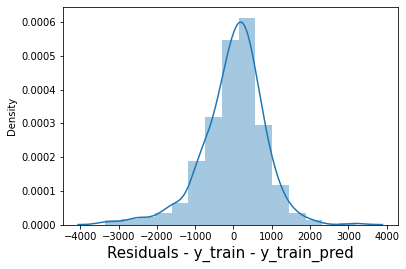

In [117]:
sns.distplot(res,bins=15)
fig.suptitle("Error Terms",fontsize=15)
plt.xlabel("Residuals - y_train - y_train_pred",fontsize=15)
plt.show()

In [118]:
# The residuals seem normally distributed

#### Lets check the R-Squared value

In [112]:
r_squared = r2_score(y_test, y_pred)

In [113]:
#coefficient of determination
r_squared

0.8146666989143738

# CONCLUSION

#### Model 3 appears to be a decent model
- With adjusted Rsquared 0.817 from OLS summary. This means	around 82% of the variation in the y values is accounted for by the x values
- Converged to 9 optimal variables from 28 original
- p values under 0.05 or 95% confidence 
- Residual error terms are normally distributed